In [1]:
import align.detect_face

In [2]:
from align.facenet import get_dataset

In [4]:
dataset = get_dataset(paths='data/CASIA-WebFace/')

# take a look of the data

In [13]:
sum(len(i.image_paths) for i in dataset)

494414

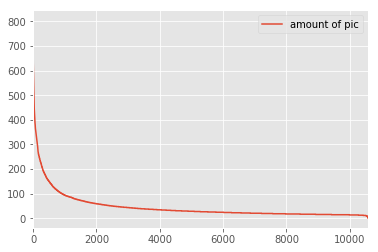

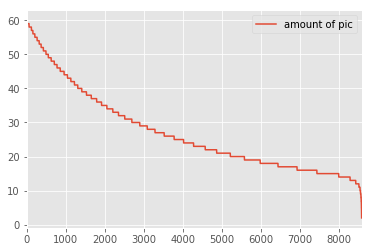

In [34]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
pd.DataFrame({'amount of pic':sorted([len(i.image_paths) for i in dataset],reverse=True)}).plot()
pd.DataFrame({'amount of pic':sorted([len(i.image_paths) for i in dataset],reverse=True)[2000:]}).plot()

In [16]:
max(len(i.image_paths) for i in dataset)

804

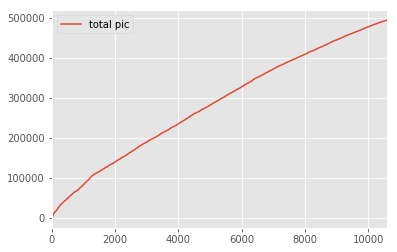

In [35]:
damount = [len(i.image_paths) for i in dataset]
for i in range(len(damount) - 1):
    damount[i + 1] += damount[i]
pd.DataFrame({'total pic':damount}).plot()

# test the image align technique

In [30]:
import align.detect_face
from scipy import misc
import tensorflow as tf

## use mtcnn

In [488]:
import align.align_dlib

In [108]:
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [109]:
with session.as_default():
    pnet, rnet, onet = align.detect_face.create_mtcnn(session, None)

## use dlib

In [159]:
align_tool = align.align_dlib.AlignDlib('data/shape_predictor_68_face_landmarks.dat')

In [160]:
landmarkIndices = align.align_dlib.AlignDlib.OUTER_EYES_AND_NOSE

## use opencv

In [328]:
facecascade = cv2.CascadeClassifier('data/haar_cascade_frontalface_default.xml')

## now run all those detectors

In [549]:
sample_file = dataset[5].image_paths[6]
#sample_file = 'sample/mmexport1474478436146.jpg'
sample_img = misc.imread(sample_file)
sample_img.shape

(250, 250, 3)

In [550]:
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709 # scale factor
bounding_boxes, _ = align.detect_face.detect_face(sample_img,250, pnet,rnet,onet,threshold,factor)

In [551]:
aligned = align_tool.align(110, sample_img, landmarkIndices=landmarkIndices,skipMulti=False)
dlib_bounders = align_tool.getAllFaceBoundingBoxes(sample_img)

In [552]:
faces = facecascade.detectMultiScale(sample_img,scaleFactor=1.1,minNeighbors=5)

In [553]:
from align.align_dlib import TEMPLATE,MINMAX_TEMPLATE
OUTER_EYES_AND_NOSE = [36, 45, 33]
landmarkIndices = OUTER_EYES_AND_NOSE
def align_pic(left,top,right,bottom,img,scale=0.78,imgDim=110):
    left = np.long(left)
    top = np.long(top)
    right = np.long(right)
    bottom = np.long(bottom)
    bb = dlib.rectangle(left,top,right,bottom)
    landmarks = align_tool.findLandmarks(img,bb)
    npLandmarks = np.float32(landmarks)
    npLandmarkIndices = np.array(landmarkIndices)
    H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                               imgDim * MINMAX_TEMPLATE[npLandmarkIndices]*scale + imgDim*(1-scale)/2)
    thumbnail = cv2.warpAffine(img, H, (imgDim, imgDim))
    return thumbnail

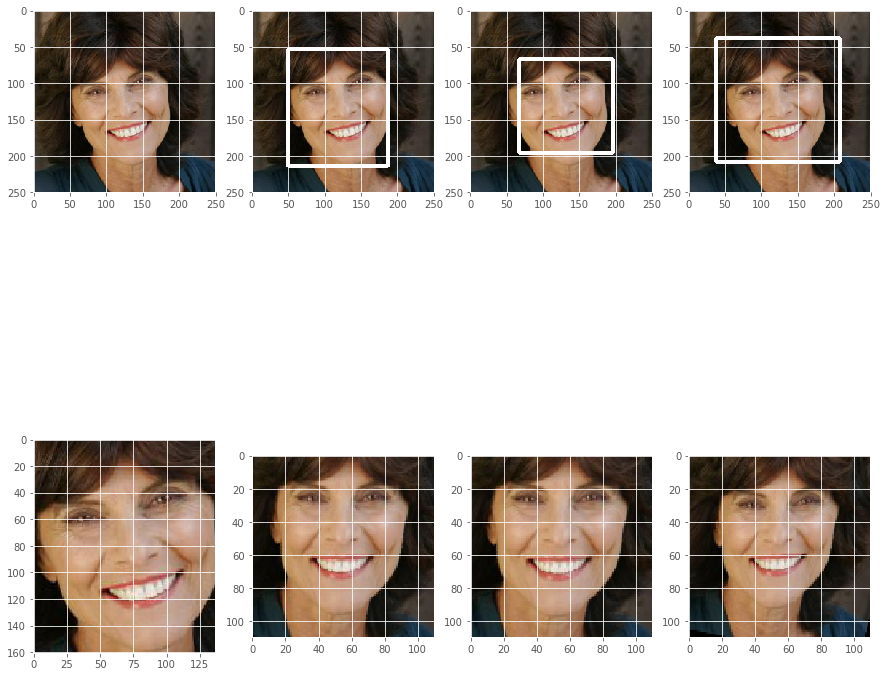

In [554]:
import cv2
import numpy as np
plt.figure(figsize=(15,15))
img_mtnn = sample_img.copy()
img_cv2 = sample_img.copy()
img_dlib = sample_img.copy()
for i_mtnn in np.asarray(bounding_boxes,dtype=np.int):
    img_mtnn = cv2.rectangle(img_mtnn,(i_mtnn[0],i_mtnn[1]),(i_mtnn[2],i_mtnn[3]),(255,255,255),4)
for i_dlib in dlib_bounders:
    img_dlib = cv2.rectangle(img_dlib,(i_dlib.left(),i_dlib.top()),(i_dlib.right(),i_dlib.bottom()),(255,255,255),4)
for i_cv2 in np.asarray(faces,dtype=np.int):
    img_cv2 = cv2.rectangle(img_cv2,(i_cv2[0],i_cv2[1]),(i_cv2[0] + i_cv2[2],i_cv2[1] + i_cv2[3]),(255,255,255),4)
    
    
plt.subplot(2,4,1)
plt.imshow(sample_img)
plt.subplot(2,4,2)
if bounding_boxes is not None:
    plt.imshow(img_mtnn)
plt.subplot(2,4,3)
if dlib_bounders is not None:
    plt.imshow(img_dlib)
plt.subplot(2,4,4)
if len(faces) > 0:
    plt.imshow(img_cv2)


plt.subplot(2,4,5)
if bounding_boxes is not None:
    plt.imshow(sample_img[i_mtnn[1]:i_mtnn[3],i_mtnn[0]:i_mtnn[2]])
plt.subplot(2,4,6)
if bounding_boxes is not None:
    plt.imshow(align_pic(i_mtnn[0],i_mtnn[1],i_mtnn[2],i_mtnn[3],sample_img))
plt.subplot(2,4,7)
if dlib_bounders is not None:
    plt.imshow(align_pic(i_dlib.left(),i_dlib.top(),i_dlib.right(),i_dlib.bottom(),sample_img))
plt.subplot(2,4,8)
if len(faces) > 0:
    plt.imshow(align_pic(
        i_cv2[0],i_cv2[1],i_cv2[0] + i_cv2[2],i_cv2[1] + i_cv2[3],sample_img))

